# Deep Learning

Deep learning is an amazing technology. Despite their shortcomings, neural networks have greatly expanded AI's potential - tackling previously untractable problems, and yielding extraodinary results in even established domains.

This notebook aims to showcase a basic implementation of a classification model using the Keras library.

### Note: Accelerating deep learning

The use of a GPU or TPU can significantly improve training times.

The TensorFlow backend (the default for Keras) requires CUDA, which is not available on Intel graphics or AMD cards.

One work arround is to use PlaidML as the Keras backend, this is described in this article: https://medium.com/@Vatsal410/keras-without-nvidia-gpus-with-plaidml-and-amd-gpu-4ba6f60025ce

in short you need to run the following commands in the terminal:

    pip install -U plaidml-keras
followed by configuring what device (GPU) you want to use by running 

    plaidml-setup

Then you need to include the following at the start of your notebook to set PlaidML as the Keras backend

    import os 
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [1]:
import os 
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# MNIST dataset

![image](https://corochann.com/wp-content/uploads/2017/02/mnist_plot-800x600.png)

This is one of the classic datasests of machine vision. It consists of low resolution images of hand-written digits.

The goal is to write a model that can injest this image, and output the digit.

In [2]:
# Loading the data
import numpy as np

# Keras provides some datasets
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical

(Xtr, ytr), (Xte, yte) = mnist.load_data()

# Note: Keras 2D-Convolutional layers expect images of shape (height x width x depth)
# where depth is 3 for an RGB image, 4 for an RGBA, or 1 for a grayscale image
def format_data(X:np.ndarray):
    'Reshapes training data'
    return X.reshape(len(X), 28, 28, 1).astype(float).dot(1/255)

# Note: For a classification task whith 10 classes, we are going to build a neural network with 
# 10 neurons in its final layer, one for each of the classes, and the model's prediction will be 
# whichever neuron is most 'stimulated' by the input image

# To do this we need a mapping:
#     0 |-> [1,0,0,0,0,0,0,0,0,0]
#     1 |-> [0,1,0,0,0,0,0,0,0,0]
#     2 |-> [0,0,1,0,0,0,0,0,0,0]
#     etc...

def format_target(y:np.ndarray):
    'One-hot encoding for the target variable'
    return to_categorical(y)

Xtr, Xte = format_data(Xtr), format_data(Xte)
ytr, yte = format_target(ytr), format_target(yte)

Using plaidml.keras.backend backend.


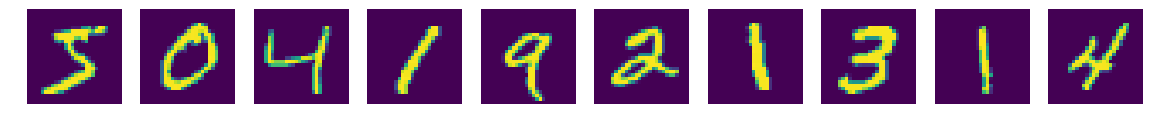

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline  

# Always good to visualize the data

fig, axes = plt.subplots(ncols=10, nrows=1)
fig.set_size_inches(20,4)
for i, ax in enumerate(axes):
    ax.imshow(Xtr[i].reshape(28,28))
    ax.axis('off')
    


As you can 'see', each image is a 28x28 pixel representation of a hand-written digit

# Reference implementation

The implementation below showcases the following features:

- Definition of architecture
- Model checkpoints


### Imports

In [4]:
# Note: This code works with the TensorFlow and PlaidML backends, but no promises.

# This is our keystone class, a wraper to our architecture that exposes a mature model api
from keras.models import Model

# The types layers in the model (the selection process can be an infinite time sink)
from keras.layers import Input, Conv2D, Dropout, Flatten, Dense, Softmax, MaxPooling2D

# A callback is like a model's side hussle. Here we'll ask the model to fit the training data
# but also to save itself to disk evey once in a while
from keras.callbacks import ModelCheckpoint

# Some visualization functionality
from keras.utils.vis_utils import plot_model, model_to_dot

### Architecture definition

![](https://wdc.objectstorage.softlayer.net/v1/AUTH_7046a6f4-79b7-4c6c-bdb7-6f68e920f6e5/Code-Articles/cc-machine-learning-deep-learning-architectures/images/figure06.png)
> Note: This image is illustrative only, not the architecture presented in this notebook.

A model's architecture is the flow of data from input to output, and what steps it has to get through. The steps are often called 'Layers'.


In [5]:
# Defining the architecture

input_layer = Input(shape=(28,28,1),  dtype='float32')

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

#randomly turn neurons on and off to improve convergence
x = Dropout(0.25)(x)

#flatten since too many dimensions, we only want a classification output
x = Flatten()(x)

#fully connected to get all relevant data
x = Dense(128, activation='relu')(x)

#one more dropout for convergence' sake :) 
x = Dropout(0.5)(x)

#output a softmax to squash the matrix into output probabilities
output_layer = Dense(10, activation='softmax', name='SoftMaxDenseLayer')(x)

INFO:plaidml:Opening device "opencl_amd_amd_radeon_pro_455_compute_engine.0"


In [6]:
# Defining the model
model = Model(inputs=input_layer, outputs=output_layer)

### Visualization

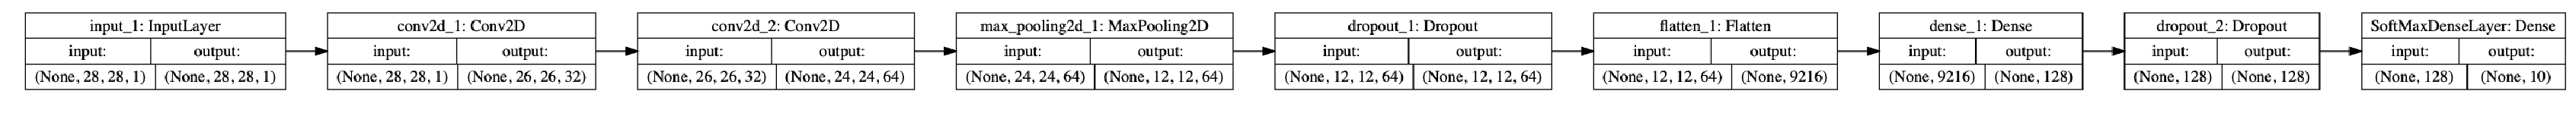

In [7]:
import matplotlib.pyplot as plt


def visualize(model):
    # Generating a png
    x = plot_model(model, show_layer_names=True, show_shapes=True, rankdir='LR')

    # Loading the png
    img = plt.imread('model.png')
    
    # Configuration
    fig = plt.figure(figsize=(60,12))
    ax = plt.gca()
    ax.imshow(img)
    ax.axis('off')    
    return ax

visualize(model)

### Performance Tracking and Training Config

In [8]:
# Compilation is where you determine the learning process, the loss, as well as any metrics you want to track during training.

from keras import metrics, optimizers

model.compile(optimizer=optimizers.Adadelta(), # Optimizers are a big topic
              loss='categorical_crossentropy', # Losses are also a big topic
              metrics=['accuracy'])


### Training

In [9]:
%%time

model.fit(Xtr, ytr,  validation_data=(Xte, yte),
          batch_size=100, epochs=5,
          callbacks=[ModelCheckpoint(filepath='Model-v1-epoch-{epoch}.hdf5')])  # starts training

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 29s 476us/step - loss: 0.5341 - acc: 0.8943 - val_loss: 0.0742 - val_acc: 0.9759
Epoch 2/5
60000/60000 [==============================] - 28s 471us/step - loss: 9.9858 - acc: 0.9419 - val_loss: 0.0623 - val_acc: 0.9799
Epoch 3/5
60000/60000 [==============================] - 28s 463us/step - loss: 0.8304 - acc: 0.9551 - val_loss: 0.0660 - val_acc: 0.9830
Epoch 4/5
60000/60000 [==============================] - 28s 466us/step - loss: 4689925341101130054489031070187520.0000 - acc: 0.9521 - val_loss: 0.0642 - val_acc: 0.9824
Epoch 5/5
60000/60000 [==============================] - 27s 457us/step - loss: 2.2139 - acc: 0.9564 - val_loss: 0.0767 - val_acc: 0.9795
CPU times: user 2min 28s, sys: 30.4 s, total: 2min 58s
Wall time: 2min 20s


### Displaying some metrics

In [10]:
import pandas as pd
history = pd.DataFrame(model.history.history)
history.head()

,val_loss,val_acc,loss,acc
0,0.074190,0.9759,5.340924e-01,0.894267
1,0.062258,0.9799,9.985835e+00,0.941933
2,0.066000,0.9830,8.303558e-01,0.955117
3,0.064181,0.9824,4.689925e+33,0.952083
4,0.076672,0.9795,2.213949e+00,0.956383


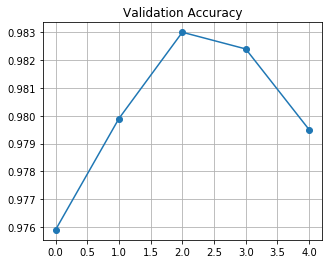

In [11]:
history['val_acc'].plot(grid=True, figsize=(len(history),4), title='Validation Accuracy', marker='o')

### Continued Training 

In [12]:
from keras.models import load_model

model_continued = load_model('Model-v1-epoch-5.hdf5')

model_continued.fit(Xtr, ytr,  validation_data=(Xte, yte),
                    batch_size=100, epochs=20, initial_epoch=5,
                    callbacks=[ModelCheckpoint(filepath='Model-v1-epoch-{epoch}.hdf5')])  # starts training

Train on 60000 samples, validate on 10000 samples
Epoch 6/20
60000/60000 [==============================] - 27s 453us/step - loss: 0.2752 - acc: 0.9583 - val_loss: 0.0701 - val_acc: 0.9823
Epoch 7/20
60000/60000 [==============================] - 27s 449us/step - loss: 0.4451 - acc: 0.9546 - val_loss: 0.0712 - val_acc: 0.9808
Epoch 8/20
60000/60000 [==============================] - 27s 448us/step - loss: 0.2489 - acc: 0.9535 - val_loss: 0.0774 - val_acc: 0.9804
Epoch 9/20
60000/60000 [==============================] - 27s 454us/step - loss: 0.2577 - acc: 0.9514 - val_loss: 0.0732 - val_acc: 0.9799
Epoch 10/20
60000/60000 [==============================] - 27s 451us/step - loss: 0.2772 - acc: 0.9492 - val_loss: 0.0830 - val_acc: 0.9801
Epoch 11/20
60000/60000 [==============================] - 27s 449us/step - loss: 0.3187 - acc: 0.9405 - val_loss: 0.0893 - val_acc: 0.9783
Epoch 12/20
60000/60000 [==============================] - 27s 452us/step - loss: 0.3421 - acc: 0.9414 - val_loss:

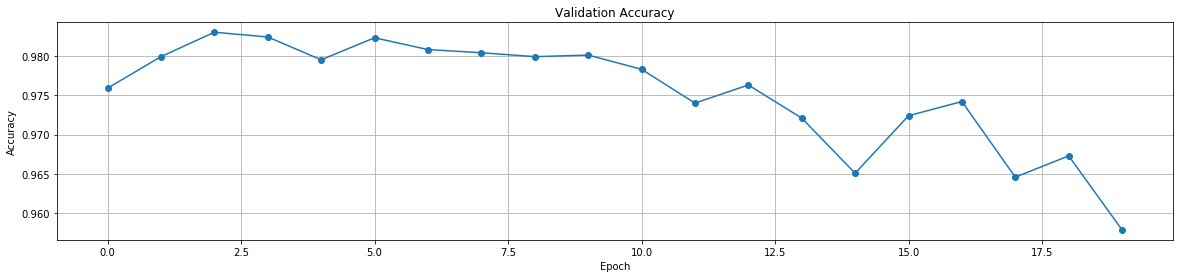

In [13]:
history = pd.DataFrame(model.history.history).append(pd.DataFrame(model_continued.history.history)).reset_index()
ax = history['val_acc'].plot(grid=True, figsize=(len(history),4), title='Validation Accuracy', marker='o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
plt.show()

Note that the Accuracy of our model does not increase beyond the 3rd epoch. This is partly due to overfitting, partly due to the loss function not being the same as our metric.

Deep learning provides a bag of tools to deal with this, from early stopping, to changing loss functions midway through training. 

In short: More training is not allways better

# Note: Kera's functional API

The way showcased above to define model architectures is very flexible. Here is an example of a (not very good) architecture defined in this style

In [14]:
from keras.layers import concatenate

input_layer = Input(shape=(28,28,1), name='InputLayer',  dtype='float32')

# Some convolutional reductions
convolutional_reduction1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
convolutional_reduction2 = Conv2D(64, (3, 3), activation='relu')(convolutional_reduction1)
convolutional_reduction3 = MaxPooling2D(pool_size=(2, 2))(convolutional_reduction2)
convolutional_reduction4 = Dropout(0.25)(convolutional_reduction3)
convolutional_reduction5 = Flatten()(convolutional_reduction4)

# Some Dense Reductions
dense_layers1 = Flatten()(input_layer)
dense_layers2 = Dense(196, activation='relu')(dense_layers1)

dense_layers3_1 = Dense(392, activation='relu')(dense_layers2)
dense_layers3_2 = Dense(392, activation='elu')(dense_layers2)
dense_layers3_3 = Dense(392, activation='softmax')(dense_layers2)

dense_layers4 = Dense(196, activation='relu')(concatenate([dense_layers3_1,dense_layers3_2,dense_layers3_3]))
dense_layers5 = Dropout(0.25)(dense_layers4)


# Joining up
joint_paths = concatenate([convolutional_reduction5, dense_layers5, dense_layers1])

#randomly turn neurons on and off to improve convergence
final_layers1 = Dropout(0.25)(joint_paths)
final_layers2 = Dense(128, activation='relu')(final_layers1)
final_layers3 = Dropout(0.5)(concatenate([final_layers2,dense_layers4]))
output_layer = Dense(10, activation='softmax')(final_layers3)

In [15]:
example = Model(inputs=input_layer, outputs=output_layer)

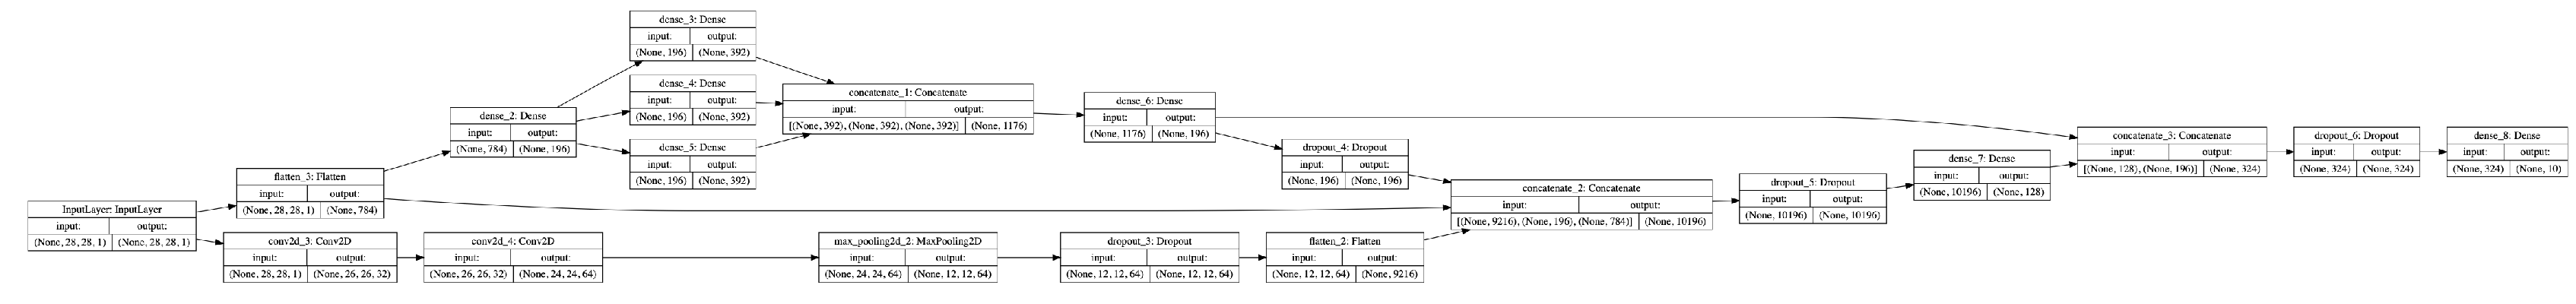

In [16]:
visualize(example)

In [17]:
# Incidetally, you can train it - but don't expect great results

example.compile(optimizer=optimizers.Adadelta(), # Optimizers are a big topic
              loss='categorical_crossentropy', # Losses are also a big topic
              metrics=['accuracy'])

example.fit(Xtr, ytr,  validation_data=(Xte, yte), batch_size=100, epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5


INFO:plaidml:Analyzing Ops: 148 of 588 operations complete


60000/60000 [==============================] - 42s 697us/step - loss: 0.2329 - acc: 0.9285 - val_loss: 0.0672 - val_acc: 0.9781
Epoch 2/5
60000/60000 [==============================] - 33s 549us/step - loss: 0.0801 - acc: 0.9754 - val_loss: 0.0505 - val_acc: 0.9841
Epoch 3/5
60000/60000 [==============================] - 33s 550us/step - loss: 0.0566 - acc: 0.9823 - val_loss: 0.0483 - val_acc: 0.9832
Epoch 4/5
60000/60000 [==============================] - 33s 551us/step - loss: 0.0433 - acc: 0.9863 - val_loss: 0.0414 - val_acc: 0.9874
Epoch 5/5
60000/60000 [==============================] - 33s 550us/step - loss: 0.0368 - acc: 0.9888 - val_loss: 0.0397 - val_acc: 0.9868
